In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric

In [2]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 5

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [16]:
# Noise distribution parameters
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = y.mean(axis=0)
    cov = np.cov(y, rowvar=False)
    
    return mu, cov

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
# Do we want to implement this: https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m ?
def get_cnce_epsilon(y):
    return np.std(y, axis=-1).mean()

In [17]:

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params():
    mu_min, mu_max = 5, 10
    sigma_min, sigma_max = 0.3, 1.5
    mu = (mu_max - mu_min) * np.random.uniform() + mu_min
    sigma = (sigma_max - sigma_min) * np.random.uniform() + sigma_min
    precision = sigma**(-2)
    z = -0.5 * np.log(2 * np.pi) - np.log(sigma);
    
    return mu, precision, z

def initialise_params():
    mu_min, mu_max = 6, 8
    sigma_min, sigma_max = 0.3, 1.5
    mu = (mu_max - mu_min) * np.random.uniform() + mu_min
    sigma = (sigma_max - sigma_min) * np.random.uniform() + sigma_min
    precision = sigma**(-2)
    
    z_min = 0.01
    z = np.random.uniform() + z_min

    return mu, np.log(precision), np.log(z)


In [18]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, z = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu, precision=precision, 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.y)
            cov_noise_cnce = torch.eye(num_dims) * get_cnce_epsilon(training_data.y)**2
                        
            # Initialise
            mu_init, log_precision_init, log_z_init = initialise_params()
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if isinstance(crit, NceBinaryCrit):
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fun=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if isinstance(crit, CondNceCrit):
                    p_n = ConditionalMultivariateNormal(mu=0, cov=sigma_noise)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs)

np.save("res/final_param_error_ring_model_all", error_res)

[1] loss: 2.661
[1] evaluation metric: 0.785
[2] loss: 2.749
[2] evaluation metric: 0.629
[3] loss: 2.268
[3] evaluation metric: 0.489
[4] loss: 2.020
[4] evaluation metric: 0.309
[5] loss: 2.343
[5] evaluation metric: 0.205
[6] loss: 2.153
[6] evaluation metric: 0.092
[7] loss: 2.004
[7] evaluation metric: 0.052
[8] loss: 1.721
[8] evaluation metric: 0.010
[9] loss: 1.890
[9] evaluation metric: 0.001
[10] loss: 0.692
[10] evaluation metric: 0.009
[11] loss: -0.074
[11] evaluation metric: 0.053
[12] loss: 0.568
[12] evaluation metric: 0.122
[13] loss: -2.548
[13] evaluation metric: 0.185
[14] loss: -4.656
[14] evaluation metric: 0.192
[15] loss: -4.508
[15] evaluation metric: 0.198
[16] loss: -4.628
[16] evaluation metric: 0.204
[17] loss: -5.070
[17] evaluation metric: 0.207
[18] loss: -5.085
[18] evaluation metric: 0.209
[19] loss: -4.936
[19] evaluation metric: 0.212
[20] loss: -4.865
[20] evaluation metric: 0.215
[21] loss: -4.971
[21] evaluation metric: 0.217
[22] loss: -4.842
[22

[77] loss: -2.428
[77] evaluation metric: 1.804
[78] loss: -2.602
[78] evaluation metric: 1.804
[79] loss: -2.530
[79] evaluation metric: 1.806
[80] loss: -2.414
[80] evaluation metric: 1.808
[81] loss: -2.707
[81] evaluation metric: 1.808
[82] loss: -2.724
[82] evaluation metric: 1.810
[83] loss: -2.672
[83] evaluation metric: 1.811
[84] loss: -2.448
[84] evaluation metric: 1.813
[85] loss: -2.557
[85] evaluation metric: 1.814
[86] loss: -2.530
[86] evaluation metric: 1.816
[87] loss: -2.609
[87] evaluation metric: 1.817
[88] loss: -2.693
[88] evaluation metric: 1.818
[89] loss: -2.599
[89] evaluation metric: 1.819
[90] loss: -2.626
[90] evaluation metric: 1.820
[91] loss: -2.538
[91] evaluation metric: 1.822
[92] loss: -2.743
[92] evaluation metric: 1.822
[93] loss: -2.728
[93] evaluation metric: 1.823
[94] loss: -2.612
[94] evaluation metric: 1.824
[95] loss: -2.732
[95] evaluation metric: 1.825
[96] loss: -2.697
[96] evaluation metric: 1.826
[97] loss: -2.773
[97] evaluation metric

[33] loss: 0.463
[33] evaluation metric: 3.606
[34] loss: 0.480
[34] evaluation metric: 3.512
[35] loss: 0.480
[35] evaluation metric: 3.216
[36] loss: 0.506
[36] evaluation metric: 3.156
[37] loss: 0.457
[37] evaluation metric: 3.180
[38] loss: 0.331
[38] evaluation metric: 3.389
[39] loss: 0.694
[39] evaluation metric: 3.235
[40] loss: 0.617
[40] evaluation metric: 3.136
[41] loss: 0.596
[41] evaluation metric: 3.029
[42] loss: 0.527
[42] evaluation metric: 3.053
[43] loss: 0.241
[43] evaluation metric: 3.073
[44] loss: 0.469
[44] evaluation metric: 3.195
[45] loss: 0.624
[45] evaluation metric: 3.347
[46] loss: 0.764
[46] evaluation metric: 3.311
[47] loss: 0.619
[47] evaluation metric: 3.331
[48] loss: 0.590
[48] evaluation metric: 3.331
[49] loss: 0.528
[49] evaluation metric: 3.332
[50] loss: 0.693
[50] evaluation metric: 3.422
[51] loss: 0.624
[51] evaluation metric: 3.235
[52] loss: 0.622
[52] evaluation metric: 3.099
[53] loss: 0.645
[53] evaluation metric: 3.135
[54] loss: 0.

[98] evaluation metric: 0.003
[99] loss: 0.390
[99] evaluation metric: 0.001
[100] loss: 0.252
[100] evaluation metric: 0.000
Finished training
Data saved
[1] loss: 1.509
[1] evaluation metric: 0.074
[2] loss: 2.003
[2] evaluation metric: 0.003
[3] loss: 1.587
[3] evaluation metric: 0.004
[4] loss: 1.702
[4] evaluation metric: 0.050
[5] loss: 0.801
[5] evaluation metric: 0.086
[6] loss: -0.864
[6] evaluation metric: 0.379
[7] loss: -3.625
[7] evaluation metric: 0.419
[8] loss: -2.433
[8] evaluation metric: 0.618
[9] loss: -3.580
[9] evaluation metric: 0.636
[10] loss: -3.918
[10] evaluation metric: 0.646
[11] loss: -3.439
[11] evaluation metric: 0.662
[12] loss: -3.971
[12] evaluation metric: 0.669
[13] loss: -3.890
[13] evaluation metric: 0.678
[14] loss: -3.547
[14] evaluation metric: 0.692
[15] loss: -4.047
[15] evaluation metric: 0.698
[16] loss: -3.901
[16] evaluation metric: 0.708
[17] loss: -3.807
[17] evaluation metric: 0.714
[18] loss: -3.733
[18] evaluation metric: 0.721
[19]

[65] loss: -0.281
[65] evaluation metric: 3.443
[66] loss: -0.270
[66] evaluation metric: 3.446
[67] loss: -0.383
[67] evaluation metric: 3.448
[68] loss: -0.264
[68] evaluation metric: 3.451
[69] loss: -0.349
[69] evaluation metric: 3.454
[70] loss: -0.253
[70] evaluation metric: 3.456
[71] loss: -0.211
[71] evaluation metric: 3.459
[72] loss: -0.133
[72] evaluation metric: 3.463
[73] loss: -0.338
[73] evaluation metric: 3.465
[74] loss: -0.355
[74] evaluation metric: 3.467
[75] loss: -0.303
[75] evaluation metric: 3.469
[76] loss: -0.244
[76] evaluation metric: 3.473
[77] loss: -0.277
[77] evaluation metric: 3.475
[78] loss: -0.218
[78] evaluation metric: 3.477
[79] loss: -0.212
[79] evaluation metric: 3.480
[80] loss: -0.180
[80] evaluation metric: 3.482
[81] loss: -0.229
[81] evaluation metric: 3.485
[82] loss: -0.214
[82] evaluation metric: 3.487
[83] loss: -0.129
[83] evaluation metric: 3.489
[84] loss: -0.463
[84] evaluation metric: 3.491
[85] loss: -0.231
[85] evaluation metric

[87] loss: -3.433
[87] evaluation metric: 0.392
[88] loss: -3.553
[88] evaluation metric: 0.392
[89] loss: -3.588
[89] evaluation metric: 0.392
[90] loss: -3.447
[90] evaluation metric: 0.392
[91] loss: -3.500
[91] evaluation metric: 0.392
[92] loss: -3.396
[92] evaluation metric: 0.393
[93] loss: -3.512
[93] evaluation metric: 0.393
[94] loss: -3.516
[94] evaluation metric: 0.393
[95] loss: -3.630
[95] evaluation metric: 0.393
[96] loss: -3.473
[96] evaluation metric: 0.393
[97] loss: -3.500
[97] evaluation metric: 0.393
[98] loss: -3.485
[98] evaluation metric: 0.394
[99] loss: -3.505
[99] evaluation metric: 0.394
[100] loss: -3.448
[100] evaluation metric: 0.394
Finished training
Data saved
[1] loss: 0.584
[1] evaluation metric: 0.000
[2] loss: 0.534
[2] evaluation metric: 0.000
[3] loss: 0.571
[3] evaluation metric: 0.000
[4] loss: 0.642
[4] evaluation metric: 0.000
[5] loss: 0.552
[5] evaluation metric: 0.000
[6] loss: 0.585
[6] evaluation metric: 0.000
[7] loss: 0.584
[7] evaluat

[61] loss: -1.935
[61] evaluation metric: 0.595
[62] loss: -2.034
[62] evaluation metric: 0.596
[63] loss: -1.983
[63] evaluation metric: 0.597
[64] loss: -2.076
[64] evaluation metric: 0.598
[65] loss: -2.112
[65] evaluation metric: 0.599
[66] loss: -2.112
[66] evaluation metric: 0.600
[67] loss: -2.094
[67] evaluation metric: 0.601
[68] loss: -2.187
[68] evaluation metric: 0.601
[69] loss: -2.259
[69] evaluation metric: 0.602
[70] loss: -2.203
[70] evaluation metric: 0.603
[71] loss: -2.093
[71] evaluation metric: 0.604
[72] loss: -2.120
[72] evaluation metric: 0.605
[73] loss: -2.005
[73] evaluation metric: 0.606
[74] loss: -2.067
[74] evaluation metric: 0.607
[75] loss: -2.007
[75] evaluation metric: 0.608
[76] loss: -2.135
[76] evaluation metric: 0.609
[77] loss: -2.173
[77] evaluation metric: 0.609
[78] loss: -2.276
[78] evaluation metric: 0.610
[79] loss: -2.108
[79] evaluation metric: 0.611
[80] loss: -2.059
[80] evaluation metric: 0.611
[81] loss: -2.209
[81] evaluation metric

[80] loss: -1.852
[80] evaluation metric: 13.385
[81] loss: -1.768
[81] evaluation metric: 13.389
[82] loss: -1.992
[82] evaluation metric: 13.392
[83] loss: -2.084
[83] evaluation metric: 13.396
[84] loss: -1.994
[84] evaluation metric: 13.399
[85] loss: -1.904
[85] evaluation metric: 13.403
[86] loss: -1.919
[86] evaluation metric: 13.406
[87] loss: -1.987
[87] evaluation metric: 13.409
[88] loss: -1.891
[88] evaluation metric: 13.412
[89] loss: -1.947
[89] evaluation metric: 13.416
[90] loss: -1.940
[90] evaluation metric: 13.419
[91] loss: -1.995
[91] evaluation metric: 13.421
[92] loss: -1.739
[92] evaluation metric: 13.425
[93] loss: -1.880
[93] evaluation metric: 13.429
[94] loss: -1.997
[94] evaluation metric: 13.431
[95] loss: -1.951
[95] evaluation metric: 13.433
[96] loss: -1.901
[96] evaluation metric: 13.435
[97] loss: -2.051
[97] evaluation metric: 13.439
[98] loss: -1.867
[98] evaluation metric: 13.442
[99] loss: -1.827
[99] evaluation metric: 13.445
[100] loss: -2.011
[

[94] loss: -3.907
[94] evaluation metric: 67.682
[95] loss: -3.877
[95] evaluation metric: 67.685
[96] loss: -3.830
[96] evaluation metric: 67.688
[97] loss: -3.822
[97] evaluation metric: 67.691
[98] loss: -4.102
[98] evaluation metric: 67.693
[99] loss: -3.741
[99] evaluation metric: 67.696
[100] loss: -3.834
[100] evaluation metric: 67.699
Finished training
Data saved
[1] loss: 0.277
[1] evaluation metric: 31.353
[2] loss: 0.309
[2] evaluation metric: 31.006
[3] loss: 0.204
[3] evaluation metric: 30.786
[4] loss: 0.261
[4] evaluation metric: 30.493
[5] loss: 0.256
[5] evaluation metric: 30.216
[6] loss: 0.236
[6] evaluation metric: 29.953
[7] loss: 0.381
[7] evaluation metric: 29.631
[8] loss: 0.182
[8] evaluation metric: 29.429
[9] loss: 0.213
[9] evaluation metric: 29.212
[10] loss: 0.196
[10] evaluation metric: 29.030
[11] loss: 0.216
[11] evaluation metric: 28.870
[12] loss: 0.223
[12] evaluation metric: 28.641
[13] loss: 0.257
[13] evaluation metric: 28.348
[14] loss: 0.245
[14

[85] loss: -0.043
[85] evaluation metric: 1.547
[86] loss: -0.014
[86] evaluation metric: 1.548
[87] loss: 0.053
[87] evaluation metric: 1.549
[88] loss: -0.063
[88] evaluation metric: 1.550
[89] loss: 0.076
[89] evaluation metric: 1.551
[90] loss: -0.226
[90] evaluation metric: 1.552
[91] loss: -0.216
[91] evaluation metric: 1.552
[92] loss: -0.029
[92] evaluation metric: 1.553
[93] loss: 0.033
[93] evaluation metric: 1.554
[94] loss: -0.046
[94] evaluation metric: 1.555
[95] loss: -0.074
[95] evaluation metric: 1.556
[96] loss: -0.186
[96] evaluation metric: 1.556
[97] loss: -0.062
[97] evaluation metric: 1.557
[98] loss: 0.000
[98] evaluation metric: 1.558
[99] loss: 0.026
[99] evaluation metric: 1.559
[100] loss: -0.082
[100] evaluation metric: 1.560
Finished training
Data saved
[1] loss: 0.636
[1] evaluation metric: 0.612
[2] loss: 0.636
[2] evaluation metric: 0.604
[3] loss: 0.633
[3] evaluation metric: 0.595
[4] loss: 0.627
[4] evaluation metric: 0.588
[5] loss: 0.687
[5] evalua

[37] loss: 0.361
[37] evaluation metric: 0.713
[38] loss: 0.408
[38] evaluation metric: 0.738
[39] loss: 0.301
[39] evaluation metric: 0.751
[40] loss: 0.352
[40] evaluation metric: 0.765
[41] loss: 0.352
[41] evaluation metric: 0.808
[42] loss: 0.295
[42] evaluation metric: 0.846
[43] loss: 0.341
[43] evaluation metric: 0.889
[44] loss: 0.374
[44] evaluation metric: 0.905
[45] loss: 0.419
[45] evaluation metric: 0.940
[46] loss: 0.264
[46] evaluation metric: 0.967
[47] loss: 0.279
[47] evaluation metric: 0.997
[48] loss: 0.351
[48] evaluation metric: 1.029
[49] loss: 0.308
[49] evaluation metric: 1.033
[50] loss: 0.354
[50] evaluation metric: 1.060
[51] loss: 0.320
[51] evaluation metric: 1.091
[52] loss: 0.349
[52] evaluation metric: 1.112
[53] loss: 0.304
[53] evaluation metric: 1.122
[54] loss: 0.264
[54] evaluation metric: 1.154
[55] loss: 0.325
[55] evaluation metric: 1.192
[56] loss: 0.270
[56] evaluation metric: 1.212
[57] loss: 0.305
[57] evaluation metric: 1.238
[58] loss: 0.

[73] loss: 0.471
[73] evaluation metric: 0.650
[74] loss: 0.464
[74] evaluation metric: 0.587
[75] loss: 0.483
[75] evaluation metric: 0.526
[76] loss: 0.616
[76] evaluation metric: 0.472
[77] loss: 0.476
[77] evaluation metric: 0.421
[78] loss: 0.512
[78] evaluation metric: 0.373
[79] loss: 0.487
[79] evaluation metric: 0.324
[80] loss: 0.527
[80] evaluation metric: 0.282
[81] loss: 0.543
[81] evaluation metric: 0.235
[82] loss: 0.404
[82] evaluation metric: 0.199
[83] loss: 0.480
[83] evaluation metric: 0.165
[84] loss: 0.480
[84] evaluation metric: 0.132
[85] loss: 0.529
[85] evaluation metric: 0.092
[86] loss: 0.514
[86] evaluation metric: 0.061
[87] loss: 0.514
[87] evaluation metric: 0.040
[88] loss: 0.483
[88] evaluation metric: 0.025
[89] loss: 0.439
[89] evaluation metric: 0.012
[90] loss: 0.456
[90] evaluation metric: 0.005
[91] loss: 0.498
[91] evaluation metric: 0.003
[92] loss: 0.526
[92] evaluation metric: 0.000
[93] loss: 0.424
[93] evaluation metric: 0.004
[94] loss: 0.

[5] loss: 1.814
[5] evaluation metric: 13.988
[6] loss: 0.839
[6] evaluation metric: 14.419
[7] loss: 1.147
[7] evaluation metric: 14.845
[8] loss: -0.455
[8] evaluation metric: 15.240
[9] loss: -1.216
[9] evaluation metric: 15.399
[10] loss: -0.390
[10] evaluation metric: 15.820
[11] loss: -1.755
[11] evaluation metric: 15.851
[12] loss: -2.190
[12] evaluation metric: 15.867
[13] loss: -1.987
[13] evaluation metric: 15.884
[14] loss: -2.161
[14] evaluation metric: 15.896
[15] loss: -2.198
[15] evaluation metric: 15.908
[16] loss: -2.025
[16] evaluation metric: 15.922
[17] loss: -2.153
[17] evaluation metric: 15.935
[18] loss: -1.972
[18] evaluation metric: 15.949
[19] loss: -2.041
[19] evaluation metric: 15.960
[20] loss: -2.146
[20] evaluation metric: 15.972
[21] loss: -2.139
[21] evaluation metric: 15.981
[22] loss: -2.184
[22] evaluation metric: 15.987
[23] loss: -2.176
[23] evaluation metric: 15.995
[24] loss: -2.175
[24] evaluation metric: 16.003
[25] loss: -2.134
[25] evaluation

[15] loss: -11.226
[15] evaluation metric: 0.281
[16] loss: -10.986
[16] evaluation metric: 0.283
[17] loss: -11.262
[17] evaluation metric: 0.285
[18] loss: -11.469
[18] evaluation metric: 0.286
[19] loss: -11.415
[19] evaluation metric: 0.288
[20] loss: -11.499
[20] evaluation metric: 0.289
[21] loss: -11.418
[21] evaluation metric: 0.290
[22] loss: -11.407
[22] evaluation metric: 0.291
[23] loss: -11.563
[23] evaluation metric: 0.292
[24] loss: -11.675
[24] evaluation metric: 0.293
[25] loss: -11.873
[25] evaluation metric: 0.294
[26] loss: -11.406
[26] evaluation metric: 0.294
[27] loss: -11.665
[27] evaluation metric: 0.295
[28] loss: -11.904
[28] evaluation metric: 0.295
[29] loss: -11.343
[29] evaluation metric: 0.296
[30] loss: -11.335
[30] evaluation metric: 0.297
[31] loss: -10.905
[31] evaluation metric: 0.298
[32] loss: -11.427
[32] evaluation metric: 0.298
[33] loss: -11.385
[33] evaluation metric: 0.299
[34] loss: -11.087
[34] evaluation metric: 0.299
[35] loss: -11.574
[

[8] loss: -3.136
[8] evaluation metric: 0.023
[9] loss: -4.772
[9] evaluation metric: 0.046
[10] loss: -4.079
[10] evaluation metric: 0.076
[11] loss: -5.656
[11] evaluation metric: 0.088
[12] loss: -4.977
[12] evaluation metric: 0.103
[13] loss: -5.084
[13] evaluation metric: 0.116
[14] loss: -5.606
[14] evaluation metric: 0.124
[15] loss: -5.625
[15] evaluation metric: 0.131
[16] loss: -5.532
[16] evaluation metric: 0.137
[17] loss: -5.483
[17] evaluation metric: 0.145
[18] loss: -5.584
[18] evaluation metric: 0.151
[19] loss: -5.192
[19] evaluation metric: 0.157
[20] loss: -5.879
[20] evaluation metric: 0.161
[21] loss: -6.014
[21] evaluation metric: 0.165
[22] loss: -5.734
[22] evaluation metric: 0.169
[23] loss: -5.823
[23] evaluation metric: 0.172
[24] loss: -6.087
[24] evaluation metric: 0.175
[25] loss: -5.748
[25] evaluation metric: 0.177
[26] loss: -5.842
[26] evaluation metric: 0.180
[27] loss: -5.830
[27] evaluation metric: 0.183
[28] loss: -5.844
[28] evaluation metric: 0.

[22] loss: -5.054
[22] evaluation metric: 3.657
[23] loss: -4.774
[23] evaluation metric: 3.665
[24] loss: -4.999
[24] evaluation metric: 3.672
[25] loss: -4.900
[25] evaluation metric: 3.681
[26] loss: -4.851
[26] evaluation metric: 3.690
[27] loss: -5.011
[27] evaluation metric: 3.697
[28] loss: -4.791
[28] evaluation metric: 3.705
[29] loss: -4.831
[29] evaluation metric: 3.711
[30] loss: -5.060
[30] evaluation metric: 3.716
[31] loss: -4.774
[31] evaluation metric: 3.724
[32] loss: -5.080
[32] evaluation metric: 3.730
[33] loss: -4.941
[33] evaluation metric: 3.735
[34] loss: -5.139
[34] evaluation metric: 3.740
[35] loss: -4.862
[35] evaluation metric: 3.744
[36] loss: -4.930
[36] evaluation metric: 3.749
[37] loss: -4.890
[37] evaluation metric: 3.753
[38] loss: -5.018
[38] evaluation metric: 3.757
[39] loss: -5.031
[39] evaluation metric: 3.761
[40] loss: -5.126
[40] evaluation metric: 3.765
[41] loss: -4.906
[41] evaluation metric: 3.769
[42] loss: -4.701
[42] evaluation metric

[100] loss: 1.152
[100] evaluation metric: 0.027
Finished training
Data saved
[1] loss: -2.025
[1] evaluation metric: 0.549
[2] loss: -8.886
[2] evaluation metric: 0.588
[3] loss: -9.327
[3] evaluation metric: 0.613
[4] loss: -9.809
[4] evaluation metric: 0.627
[5] loss: -9.624
[5] evaluation metric: 0.642
[6] loss: -9.228
[6] evaluation metric: 0.657
[7] loss: -9.755
[7] evaluation metric: 0.668
[8] loss: -9.633
[8] evaluation metric: 0.677
[9] loss: -9.878
[9] evaluation metric: 0.685
[10] loss: -9.182
[10] evaluation metric: 0.693
[11] loss: -9.417
[11] evaluation metric: 0.703
[12] loss: -9.976
[12] evaluation metric: 0.708
[13] loss: -9.567
[13] evaluation metric: 0.712
[14] loss: -9.902
[14] evaluation metric: 0.716
[15] loss: -9.719
[15] evaluation metric: 0.720
[16] loss: -10.014
[16] evaluation metric: 0.722
[17] loss: -9.980
[17] evaluation metric: 0.725
[18] loss: -9.952
[18] evaluation metric: 0.727
[19] loss: -9.669
[19] evaluation metric: 0.730
[20] loss: -10.050
[20] eva

[2] loss: -4.169
[2] evaluation metric: 0.066
[3] loss: -5.184
[3] evaluation metric: 0.106
[4] loss: -5.970
[4] evaluation metric: 0.128
[5] loss: -5.501
[5] evaluation metric: 0.154
[6] loss: -5.684
[6] evaluation metric: 0.175
[7] loss: -5.973
[7] evaluation metric: 0.189
[8] loss: -6.627
[8] evaluation metric: 0.198
[9] loss: -6.760
[9] evaluation metric: 0.203
[10] loss: -6.265
[10] evaluation metric: 0.210
[11] loss: -6.743
[11] evaluation metric: 0.215
[12] loss: -6.802
[12] evaluation metric: 0.220
[13] loss: -6.638
[13] evaluation metric: 0.225
[14] loss: -6.581
[14] evaluation metric: 0.229
[15] loss: -6.575
[15] evaluation metric: 0.233
[16] loss: -6.898
[16] evaluation metric: 0.236
[17] loss: -6.534
[17] evaluation metric: 0.239
[18] loss: -6.994
[18] evaluation metric: 0.241
[19] loss: -6.757
[19] evaluation metric: 0.243
[20] loss: -6.788
[20] evaluation metric: 0.246
[21] loss: -6.787
[21] evaluation metric: 0.248
[22] loss: -7.147
[22] evaluation metric: 0.249
[23] los

[94] loss: 1.156
[94] evaluation metric: 0.049
[95] loss: 1.134
[95] evaluation metric: 0.048
[96] loss: 1.278
[96] evaluation metric: 0.049
[97] loss: 1.311
[97] evaluation metric: 0.051
[98] loss: 1.280
[98] evaluation metric: 0.051
[99] loss: 1.366
[99] evaluation metric: 0.052
[100] loss: 1.362
[100] evaluation metric: 0.053
Finished training
Data saved
[1] loss: 4.206
[1] evaluation metric: 5.260
[2] loss: 1.596
[2] evaluation metric: 6.372
[3] loss: -4.134
[3] evaluation metric: 6.763
[4] loss: -6.373
[4] evaluation metric: 6.887
[5] loss: -6.311
[5] evaluation metric: 6.980
[6] loss: -6.463
[6] evaluation metric: 7.033
[7] loss: -6.943
[7] evaluation metric: 7.062
[8] loss: -7.010
[8] evaluation metric: 7.088
[9] loss: -7.294
[9] evaluation metric: 7.111
[10] loss: -7.115
[10] evaluation metric: 7.128
[11] loss: -7.034
[11] evaluation metric: 7.145
[12] loss: -7.276
[12] evaluation metric: 7.157
[13] loss: -7.134
[13] evaluation metric: 7.169
[14] loss: -6.961
[14] evaluation me

[76] loss: 0.500
[76] evaluation metric: 0.253
[77] loss: 0.494
[77] evaluation metric: 0.233
[78] loss: 0.451
[78] evaluation metric: 0.208
[79] loss: 0.482
[79] evaluation metric: 0.187
[80] loss: 0.462
[80] evaluation metric: 0.169
[81] loss: 0.525
[81] evaluation metric: 0.156
[82] loss: 0.391
[82] evaluation metric: 0.143
[83] loss: 0.474
[83] evaluation metric: 0.130
[84] loss: 0.470
[84] evaluation metric: 0.112
[85] loss: 0.374
[85] evaluation metric: 0.095
[86] loss: 0.336
[86] evaluation metric: 0.080
[87] loss: 0.357
[87] evaluation metric: 0.069
[88] loss: 0.484
[88] evaluation metric: 0.064
[89] loss: 0.336
[89] evaluation metric: 0.050
[90] loss: 0.447
[90] evaluation metric: 0.037
[91] loss: 0.330
[91] evaluation metric: 0.032
[92] loss: 0.491
[92] evaluation metric: 0.028
[93] loss: 0.298
[93] evaluation metric: 0.023
[94] loss: 0.459
[94] evaluation metric: 0.017
[95] loss: 0.405
[95] evaluation metric: 0.010
[96] loss: 0.426
[96] evaluation metric: 0.006
[97] loss: 0.

[81] loss: 0.868
[81] evaluation metric: 0.001
[82] loss: 0.955
[82] evaluation metric: 0.001
[83] loss: 0.853
[83] evaluation metric: 0.001
[84] loss: 0.935
[84] evaluation metric: 0.002
[85] loss: 0.977
[85] evaluation metric: 0.002
[86] loss: 1.012
[86] evaluation metric: 0.001
[87] loss: 0.901
[87] evaluation metric: 0.001
[88] loss: 0.867
[88] evaluation metric: 0.001
[89] loss: 0.927
[89] evaluation metric: 0.001
[90] loss: 0.925
[90] evaluation metric: 0.001
[91] loss: 0.829
[91] evaluation metric: 0.002
[92] loss: 1.070
[92] evaluation metric: 0.002
[93] loss: 0.870
[93] evaluation metric: 0.002
[94] loss: 1.143
[94] evaluation metric: 0.002
[95] loss: 1.008
[95] evaluation metric: 0.002
[96] loss: 0.965
[96] evaluation metric: 0.002
[97] loss: 0.964
[97] evaluation metric: 0.002
[98] loss: 0.875
[98] evaluation metric: 0.003
[99] loss: 0.969
[99] evaluation metric: 0.002
[100] loss: 0.943
[100] evaluation metric: 0.002
Finished training
Data saved
[1] loss: 3.679
[1] evaluatio

[88] loss: 1.161
[88] evaluation metric: 0.000
[89] loss: 1.248
[89] evaluation metric: 0.000
[90] loss: 1.048
[90] evaluation metric: 0.000
[91] loss: 1.083
[91] evaluation metric: 0.000
[92] loss: 0.990
[92] evaluation metric: 0.000
[93] loss: 1.225
[93] evaluation metric: 0.000
[94] loss: 0.988
[94] evaluation metric: 0.000
[95] loss: 1.019
[95] evaluation metric: 0.000
[96] loss: 1.116
[96] evaluation metric: 0.000
[97] loss: 1.090
[97] evaluation metric: 0.000
[98] loss: 1.088
[98] evaluation metric: 0.000
[99] loss: 1.164
[99] evaluation metric: 0.000
[100] loss: 1.215
[100] evaluation metric: 0.000
Finished training
Data saved
[1] loss: 5.098
[1] evaluation metric: 0.203
[2] loss: 2.095
[2] evaluation metric: 0.531
[3] loss: -5.388
[3] evaluation metric: 0.629
[4] loss: -6.139
[4] evaluation metric: 0.679
[5] loss: -6.400
[5] evaluation metric: 0.707
[6] loss: -6.524
[6] evaluation metric: 0.725
[7] loss: -6.950
[7] evaluation metric: 0.737
[8] loss: -6.994
[8] evaluation metric

[97] loss: 0.751
[97] evaluation metric: 0.040
[98] loss: 0.703
[98] evaluation metric: 0.042
[99] loss: 0.662
[99] evaluation metric: 0.042
[100] loss: 0.809
[100] evaluation metric: 0.040
Finished training
Data saved
[1] loss: -0.596
[1] evaluation metric: 0.421
[2] loss: -2.564
[2] evaluation metric: 0.510
[3] loss: -2.176
[3] evaluation metric: 0.594
[4] loss: -3.147
[4] evaluation metric: 0.632
[5] loss: -2.966
[5] evaluation metric: 0.663
[6] loss: -3.262
[6] evaluation metric: 0.683
[7] loss: -3.372
[7] evaluation metric: 0.699
[8] loss: -3.979
[8] evaluation metric: 0.711
[9] loss: -3.687
[9] evaluation metric: 0.721
[10] loss: -3.855
[10] evaluation metric: 0.730
[11] loss: -3.809
[11] evaluation metric: 0.738
[12] loss: -4.060
[12] evaluation metric: 0.744
[13] loss: -3.781
[13] evaluation metric: 0.750
[14] loss: -3.968
[14] evaluation metric: 0.755
[15] loss: -4.132
[15] evaluation metric: 0.759
[16] loss: -3.979
[16] evaluation metric: 0.764
[17] loss: -4.114
[17] evaluati

[10] loss: -0.957
[10] evaluation metric: 0.250
[11] loss: -0.957
[11] evaluation metric: 0.257
[12] loss: -1.021
[12] evaluation metric: 0.264
[13] loss: -1.363
[13] evaluation metric: 0.268
[14] loss: -1.158
[14] evaluation metric: 0.273
[15] loss: -1.344
[15] evaluation metric: 0.277
[16] loss: -1.235
[16] evaluation metric: 0.281
[17] loss: -1.415
[17] evaluation metric: 0.284
[18] loss: -1.344
[18] evaluation metric: 0.286
[19] loss: -1.327
[19] evaluation metric: 0.289
[20] loss: -1.620
[20] evaluation metric: 0.291
[21] loss: -1.286
[21] evaluation metric: 0.294
[22] loss: -1.562
[22] evaluation metric: 0.296
[23] loss: -1.428
[23] evaluation metric: 0.298
[24] loss: -1.385
[24] evaluation metric: 0.300
[25] loss: -1.441
[25] evaluation metric: 0.301
[26] loss: -1.616
[26] evaluation metric: 0.302
[27] loss: -1.500
[27] evaluation metric: 0.304
[28] loss: -1.473
[28] evaluation metric: 0.305
[29] loss: -1.467
[29] evaluation metric: 0.306
[30] loss: -1.617
[30] evaluation metric

[93] loss: 1.167
[93] evaluation metric: 0.001
[94] loss: 1.147
[94] evaluation metric: 0.000
[95] loss: 1.180
[95] evaluation metric: 0.000
[96] loss: 1.165
[96] evaluation metric: 0.000
[97] loss: 1.147
[97] evaluation metric: 0.000
[98] loss: 1.225
[98] evaluation metric: 0.000
[99] loss: 1.227
[99] evaluation metric: 0.001
[100] loss: 1.162
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: 5.024
[1] evaluation metric: 2.638
[2] loss: 1.693
[2] evaluation metric: 3.097
[3] loss: -0.932
[3] evaluation metric: 3.366
[4] loss: -2.161
[4] evaluation metric: 3.457
[5] loss: -2.148
[5] evaluation metric: 3.522
[6] loss: -2.752
[6] evaluation metric: 3.556
[7] loss: -2.601
[7] evaluation metric: 3.591
[8] loss: -2.762
[8] evaluation metric: 3.618
[9] loss: -3.044
[9] evaluation metric: 3.636
[10] loss: -3.096
[10] evaluation metric: 3.649
[11] loss: -3.005
[11] evaluation metric: 3.664
[12] loss: -3.256
[12] evaluation metric: 3.674
[13] loss: -3.092
[13] evaluation met

[11] evaluation metric: 5.754
[12] loss: 0.791
[12] evaluation metric: 5.788
[13] loss: 0.557
[13] evaluation metric: 5.810
[14] loss: 0.320
[14] evaluation metric: 5.829
[15] loss: 0.709
[15] evaluation metric: 5.854
[16] loss: 0.609
[16] evaluation metric: 5.874
[17] loss: 0.538
[17] evaluation metric: 5.892
[18] loss: 0.573
[18] evaluation metric: 5.910
[19] loss: 0.512
[19] evaluation metric: 5.926
[20] loss: 0.528
[20] evaluation metric: 5.941
[21] loss: 0.490
[21] evaluation metric: 5.953
[22] loss: 0.509
[22] evaluation metric: 5.964
[23] loss: 0.442
[23] evaluation metric: 5.975
[24] loss: 0.504
[24] evaluation metric: 5.985
[25] loss: 0.505
[25] evaluation metric: 5.996
[26] loss: 0.441
[26] evaluation metric: 6.004
[27] loss: 0.444
[27] evaluation metric: 6.013
[28] loss: 0.407
[28] evaluation metric: 6.020
[29] loss: 0.648
[29] evaluation metric: 6.029
[30] loss: 0.405
[30] evaluation metric: 6.036
[31] loss: 0.259
[31] evaluation metric: 6.041
[32] loss: 0.467
[32] evaluati

[21] loss: -2.485
[21] evaluation metric: 3.818
[22] loss: -2.440
[22] evaluation metric: 3.839
[23] loss: -2.825
[23] evaluation metric: 3.854
[24] loss: -2.660
[24] evaluation metric: 3.869
[25] loss: -2.714
[25] evaluation metric: 3.881
[26] loss: -2.803
[26] evaluation metric: 3.891
[27] loss: -2.799
[27] evaluation metric: 3.902
[28] loss: -2.760
[28] evaluation metric: 3.910
[29] loss: -2.705
[29] evaluation metric: 3.919
[30] loss: -2.701
[30] evaluation metric: 3.927
[31] loss: -2.864
[31] evaluation metric: 3.934
[32] loss: -2.855
[32] evaluation metric: 3.940
[33] loss: -2.929
[33] evaluation metric: 3.946
[34] loss: -2.819
[34] evaluation metric: 3.951
[35] loss: -2.898
[35] evaluation metric: 3.956
[36] loss: -3.072
[36] evaluation metric: 3.961
[37] loss: -3.094
[37] evaluation metric: 3.964
[38] loss: -2.871
[38] evaluation metric: 3.968
[39] loss: -2.884
[39] evaluation metric: 3.972
[40] loss: -2.943
[40] evaluation metric: 3.976
[41] loss: -3.038
[41] evaluation metric

[33] loss: 0.251
[33] evaluation metric: 0.352
[34] loss: 0.164
[34] evaluation metric: 0.353
[35] loss: 0.298
[35] evaluation metric: 0.355
[36] loss: 0.151
[36] evaluation metric: 0.356
[37] loss: 0.412
[37] evaluation metric: 0.357
[38] loss: 0.144
[38] evaluation metric: 0.359
[39] loss: 0.059
[39] evaluation metric: 0.360
[40] loss: 0.313
[40] evaluation metric: 0.361
[41] loss: 0.086
[41] evaluation metric: 0.362
[42] loss: 0.271
[42] evaluation metric: 0.363
[43] loss: 0.002
[43] evaluation metric: 0.364
[44] loss: 0.203
[44] evaluation metric: 0.365
[45] loss: 0.034
[45] evaluation metric: 0.365
[46] loss: 0.067
[46] evaluation metric: 0.366
[47] loss: 0.074
[47] evaluation metric: 0.367
[48] loss: 0.137
[48] evaluation metric: 0.368
[49] loss: 0.191
[49] evaluation metric: 0.369
[50] loss: 0.231
[50] evaluation metric: 0.369
[51] loss: 0.246
[51] evaluation metric: 0.370
[52] loss: 0.132
[52] evaluation metric: 0.371
[53] loss: 0.075
[53] evaluation metric: 0.371
[54] loss: 0.

[37] loss: -14.043
[37] evaluation metric: 1.272
[38] loss: -13.667
[38] evaluation metric: 1.274
[39] loss: -13.677
[39] evaluation metric: 1.276
[40] loss: -13.472
[40] evaluation metric: 1.277
[41] loss: -13.274
[41] evaluation metric: 1.279
[42] loss: -13.333
[42] evaluation metric: 1.281
[43] loss: -13.465
[43] evaluation metric: 1.282
[44] loss: -13.264
[44] evaluation metric: 1.283
[45] loss: -13.965
[45] evaluation metric: 1.284
[46] loss: -13.454
[46] evaluation metric: 1.286
[47] loss: -13.445
[47] evaluation metric: 1.287
[48] loss: -13.608
[48] evaluation metric: 1.288
[49] loss: -13.290
[49] evaluation metric: 1.289
[50] loss: -13.202
[50] evaluation metric: 1.290
[51] loss: -14.631
[51] evaluation metric: 1.291
[52] loss: -13.633
[52] evaluation metric: 1.292
[53] loss: -13.942
[53] evaluation metric: 1.293
[54] loss: -13.589
[54] evaluation metric: 1.293
[55] loss: -13.327
[55] evaluation metric: 1.294
[56] loss: -13.935
[56] evaluation metric: 1.295
[57] loss: -13.665
[

[36] loss: -14.585
[36] evaluation metric: 1.792
[37] loss: -14.989
[37] evaluation metric: 1.793
[38] loss: -15.149
[38] evaluation metric: 1.795
[39] loss: -15.499
[39] evaluation metric: 1.796
[40] loss: -15.426
[40] evaluation metric: 1.797
[41] loss: -15.010
[41] evaluation metric: 1.799
[42] loss: -15.290
[42] evaluation metric: 1.800
[43] loss: -15.024
[43] evaluation metric: 1.801
[44] loss: -14.708
[44] evaluation metric: 1.802
[45] loss: -14.692
[45] evaluation metric: 1.804
[46] loss: -15.085
[46] evaluation metric: 1.804
[47] loss: -14.844
[47] evaluation metric: 1.805
[48] loss: -14.661
[48] evaluation metric: 1.806
[49] loss: -15.985
[49] evaluation metric: 1.807
[50] loss: -14.697
[50] evaluation metric: 1.808
[51] loss: -14.753
[51] evaluation metric: 1.809
[52] loss: -15.022
[52] evaluation metric: 1.810
[53] loss: -14.854
[53] evaluation metric: 1.810
[54] loss: -14.762
[54] evaluation metric: 1.811
[55] loss: -15.046
[55] evaluation metric: 1.812
[56] loss: -15.129
[

[47] loss: -17.465
[47] evaluation metric: 62.517
[48] loss: -17.794
[48] evaluation metric: 62.521
[49] loss: -17.811
[49] evaluation metric: 62.526
[50] loss: -17.056
[50] evaluation metric: 62.531
[51] loss: -17.750
[51] evaluation metric: 62.535
[52] loss: -18.125
[52] evaluation metric: 62.539
[53] loss: -17.430
[53] evaluation metric: 62.542
[54] loss: -17.559
[54] evaluation metric: 62.546
[55] loss: -17.144
[55] evaluation metric: 62.550
[56] loss: -18.058
[56] evaluation metric: 62.553
[57] loss: -17.952
[57] evaluation metric: 62.556
[58] loss: -17.354
[58] evaluation metric: 62.560
[59] loss: -17.591
[59] evaluation metric: 62.562
[60] loss: -17.762
[60] evaluation metric: 62.566
[61] loss: -17.615
[61] evaluation metric: 62.569
[62] loss: -17.804
[62] evaluation metric: 62.573
[63] loss: -17.568
[63] evaluation metric: 62.575
[64] loss: -17.421
[64] evaluation metric: 62.579
[65] loss: -17.797
[65] evaluation metric: 62.581
[66] loss: -17.771
[66] evaluation metric: 62.583


[17] loss: -17.793
[17] evaluation metric: 0.866
[18] loss: -17.499
[18] evaluation metric: 0.870
[19] loss: -17.793
[19] evaluation metric: 0.874
[20] loss: -17.134
[20] evaluation metric: 0.877
[21] loss: -17.312
[21] evaluation metric: 0.880
[22] loss: -18.344
[22] evaluation metric: 0.882
[23] loss: -17.261
[23] evaluation metric: 0.885
[24] loss: -17.350
[24] evaluation metric: 0.887
[25] loss: -18.029
[25] evaluation metric: 0.889
[26] loss: -17.219
[26] evaluation metric: 0.892
[27] loss: -17.385
[27] evaluation metric: 0.894
[28] loss: -18.238
[28] evaluation metric: 0.895
[29] loss: -18.002
[29] evaluation metric: 0.897
[30] loss: -18.272
[30] evaluation metric: 0.898
[31] loss: -18.038
[31] evaluation metric: 0.899
[32] loss: -17.957
[32] evaluation metric: 0.900
[33] loss: -18.719
[33] evaluation metric: 0.901
[34] loss: -17.401
[34] evaluation metric: 0.903
[35] loss: -17.807
[35] evaluation metric: 0.904
[36] loss: -17.509
[36] evaluation metric: 0.905
[37] loss: -17.799
[

[88] loss: 1.908
[88] evaluation metric: 0.052
[89] loss: 2.330
[89] evaluation metric: 0.057
[90] loss: 2.308
[90] evaluation metric: 0.064
[91] loss: 1.884
[91] evaluation metric: 0.060
[92] loss: 1.803
[92] evaluation metric: 0.054
[93] loss: 2.254
[93] evaluation metric: 0.061
[94] loss: 2.110
[94] evaluation metric: 0.065
[95] loss: 2.112
[95] evaluation metric: 0.065
[96] loss: 2.123
[96] evaluation metric: 0.061
[97] loss: 1.807
[97] evaluation metric: 0.051
[98] loss: 1.918
[98] evaluation metric: 0.047
[99] loss: 2.093
[99] evaluation metric: 0.052
[100] loss: 2.017
[100] evaluation metric: 0.046
Finished training
Data saved
[1] loss: 11.451
[1] evaluation metric: 44.488
[2] loss: 10.509
[2] evaluation metric: 64.471
[3] loss: 9.113
[3] evaluation metric: 98.878
[4] loss: 4.591
[4] evaluation metric: 113.909
[5] loss: -14.366
[5] evaluation metric: 118.753
[6] loss: -18.681
[6] evaluation metric: 119.894
[7] loss: -20.227
[7] evaluation metric: 120.224
[8] loss: -19.813
[8] ev

[66] loss: nan
[66] evaluation metric: nan
[67] loss: nan
[67] evaluation metric: nan
[68] loss: nan
[68] evaluation metric: nan
[69] loss: nan
[69] evaluation metric: nan
[70] loss: nan
[70] evaluation metric: nan
[71] loss: nan
[71] evaluation metric: nan
[72] loss: nan
[72] evaluation metric: nan
[73] loss: nan
[73] evaluation metric: nan
[74] loss: nan
[74] evaluation metric: nan
[75] loss: nan
[75] evaluation metric: nan
[76] loss: nan
[76] evaluation metric: nan
[77] loss: nan
[77] evaluation metric: nan
[78] loss: nan
[78] evaluation metric: nan
[79] loss: nan
[79] evaluation metric: nan
[80] loss: nan
[80] evaluation metric: nan
[81] loss: nan
[81] evaluation metric: nan
[82] loss: nan
[82] evaluation metric: nan
[83] loss: nan
[83] evaluation metric: nan
[84] loss: nan
[84] evaluation metric: nan
[85] loss: nan
[85] evaluation metric: nan
[86] loss: nan
[86] evaluation metric: nan
[87] loss: nan
[87] evaluation metric: nan
[88] loss: nan
[88] evaluation metric: nan
[89] loss: 

[43] loss: 2.289
[43] evaluation metric: 0.387
[44] loss: 1.975
[44] evaluation metric: 0.376
[45] loss: 2.090
[45] evaluation metric: 0.368
[46] loss: 2.344
[46] evaluation metric: 0.383
[47] loss: 2.142
[47] evaluation metric: 0.378
[48] loss: 2.078
[48] evaluation metric: 0.385
[49] loss: 2.116
[49] evaluation metric: 0.388
[50] loss: 2.140
[50] evaluation metric: 0.378
[51] loss: 2.136
[51] evaluation metric: 0.368
[52] loss: 2.056
[52] evaluation metric: 0.363
[53] loss: 2.057
[53] evaluation metric: 0.343
[54] loss: 2.150
[54] evaluation metric: 0.333
[55] loss: 1.994
[55] evaluation metric: 0.320
[56] loss: 2.027
[56] evaluation metric: 0.324
[57] loss: 2.125
[57] evaluation metric: 0.322
[58] loss: 2.289
[58] evaluation metric: 0.343
[59] loss: 1.909
[59] evaluation metric: 0.337
[60] loss: 2.219
[60] evaluation metric: 0.334
[61] loss: 2.398
[61] evaluation metric: 0.342
[62] loss: 2.161
[62] evaluation metric: 0.340
[63] loss: 2.129
[63] evaluation metric: 0.336
[64] loss: 2.

[16] loss: 1.444
[16] evaluation metric: 0.095
[17] loss: 1.337
[17] evaluation metric: 0.096
[18] loss: 1.289
[18] evaluation metric: 0.104
[19] loss: 1.267
[19] evaluation metric: 0.099
[20] loss: 1.258
[20] evaluation metric: 0.110
[21] loss: 1.500
[21] evaluation metric: 0.105
[22] loss: 1.341
[22] evaluation metric: 0.097
[23] loss: 1.278
[23] evaluation metric: 0.108
[24] loss: 1.347
[24] evaluation metric: 0.119
[25] loss: 1.396
[25] evaluation metric: 0.098
[26] loss: 1.310
[26] evaluation metric: 0.116
[27] loss: 1.556
[27] evaluation metric: 0.095
[28] loss: 1.485
[28] evaluation metric: 0.077
[29] loss: 1.338
[29] evaluation metric: 0.069
[30] loss: 1.243
[30] evaluation metric: 0.081
[31] loss: 1.466
[31] evaluation metric: 0.070
[32] loss: 1.636
[32] evaluation metric: 0.026
[33] loss: 1.185
[33] evaluation metric: 0.042
[34] loss: 1.380
[34] evaluation metric: 0.041
[35] loss: 1.364
[35] evaluation metric: 0.047
[36] loss: 1.263
[36] evaluation metric: 0.047
[37] loss: 1.

[88] loss: -11.061
[88] evaluation metric: 0.815
[89] loss: -11.406
[89] evaluation metric: 0.815
[90] loss: -10.818
[90] evaluation metric: 0.815
[91] loss: -10.853
[91] evaluation metric: 0.815
[92] loss: -10.838
[92] evaluation metric: 0.816
[93] loss: -10.683
[93] evaluation metric: 0.816
[94] loss: -10.405
[94] evaluation metric: 0.816
[95] loss: -10.748
[95] evaluation metric: 0.816
[96] loss: -10.765
[96] evaluation metric: 0.816
[97] loss: -10.597
[97] evaluation metric: 0.816
[98] loss: -10.916
[98] evaluation metric: 0.816
[99] loss: -10.674
[99] evaluation metric: 0.816
[100] loss: -10.513
[100] evaluation metric: 0.817
Finished training
Data saved
[1] loss: 7.382
[1] evaluation metric: 18.405
[2] loss: 4.604
[2] evaluation metric: 7.164
[3] loss: 3.053
[3] evaluation metric: 4.237
[4] loss: 2.588
[4] evaluation metric: 2.644
[5] loss: 2.186
[5] evaluation metric: 1.991
[6] loss: 4.129
[6] evaluation metric: 0.619
[7] loss: 2.200
[7] evaluation metric: 0.465
[8] loss: 2.061


[82] loss: -17.804
[82] evaluation metric: 1.174
[83] loss: -17.762
[83] evaluation metric: 1.174
[84] loss: -17.828
[84] evaluation metric: 1.174
[85] loss: -17.709
[85] evaluation metric: 1.175
[86] loss: -17.841
[86] evaluation metric: 1.175
[87] loss: -18.248
[87] evaluation metric: 1.175
[88] loss: -17.789
[88] evaluation metric: 1.175
[89] loss: -17.902
[89] evaluation metric: 1.175
[90] loss: -17.829
[90] evaluation metric: 1.175
[91] loss: -18.186
[91] evaluation metric: 1.175
[92] loss: -18.168
[92] evaluation metric: 1.175
[93] loss: -17.743
[93] evaluation metric: 1.175
[94] loss: -18.145
[94] evaluation metric: 1.175
[95] loss: -17.807
[95] evaluation metric: 1.175
[96] loss: -17.519
[96] evaluation metric: 1.176
[97] loss: -17.697
[97] evaluation metric: 1.176
[98] loss: -17.968
[98] evaluation metric: 1.176
[99] loss: -17.534
[99] evaluation metric: 1.176
[100] loss: -17.401
[100] evaluation metric: 1.176
Finished training
Data saved
[1] loss: 1.675
[1] evaluation metric:

[82] loss: -6.029
[82] evaluation metric: 0.242
[83] loss: -6.463
[83] evaluation metric: 0.242
[84] loss: -6.979
[84] evaluation metric: 0.242
[85] loss: -6.212
[85] evaluation metric: 0.242
[86] loss: -5.787
[86] evaluation metric: 0.242
[87] loss: -6.244
[87] evaluation metric: 0.242
[88] loss: -6.642
[88] evaluation metric: 0.242
[89] loss: -6.076
[89] evaluation metric: 0.243
[90] loss: -7.356
[90] evaluation metric: 0.243
[91] loss: -5.951
[91] evaluation metric: 0.243
[92] loss: -6.175
[92] evaluation metric: 0.243
[93] loss: -6.178
[93] evaluation metric: 0.243
[94] loss: -6.656
[94] evaluation metric: 0.243
[95] loss: -5.940
[95] evaluation metric: 0.243
[96] loss: -6.396
[96] evaluation metric: 0.243
[97] loss: -6.201
[97] evaluation metric: 0.243
[98] loss: -6.449
[98] evaluation metric: 0.244
[99] loss: -6.091
[99] evaluation metric: 0.244
[100] loss: -6.498
[100] evaluation metric: 0.244
Finished training
Data saved
[1] loss: 2.761
[1] evaluation metric: 0.000
[2] loss: 2.

[56] loss: -7.715
[56] evaluation metric: 44.805
[57] loss: -7.538
[57] evaluation metric: 44.807
[58] loss: -6.964
[58] evaluation metric: 44.809
[59] loss: -7.255
[59] evaluation metric: 44.811
[60] loss: -7.378
[60] evaluation metric: 44.813
[61] loss: -7.886
[61] evaluation metric: 44.814
[62] loss: -7.667
[62] evaluation metric: 44.816
[63] loss: -7.582
[63] evaluation metric: 44.817
[64] loss: -7.397
[64] evaluation metric: 44.819
[65] loss: -7.308
[65] evaluation metric: 44.820
[66] loss: -7.514
[66] evaluation metric: 44.822
[67] loss: -7.784
[67] evaluation metric: 44.823
[68] loss: -7.820
[68] evaluation metric: 44.825
[69] loss: -7.559
[69] evaluation metric: 44.826
[70] loss: -7.537
[70] evaluation metric: 44.827
[71] loss: -7.531
[71] evaluation metric: 44.829
[72] loss: -7.655
[72] evaluation metric: 44.830
[73] loss: -7.712
[73] evaluation metric: 44.831
[74] loss: -7.550
[74] evaluation metric: 44.832
[75] loss: -7.690
[75] evaluation metric: 44.833
[76] loss: -8.142
[7

[36] loss: -11.927
[36] evaluation metric: 0.249
[37] loss: -12.217
[37] evaluation metric: 0.249
[38] loss: -12.202
[38] evaluation metric: 0.249
[39] loss: -11.944
[39] evaluation metric: 0.250
[40] loss: -12.108
[40] evaluation metric: 0.250
[41] loss: -11.852
[41] evaluation metric: 0.250
[42] loss: -12.033
[42] evaluation metric: 0.250
[43] loss: -12.087
[43] evaluation metric: 0.250
[44] loss: -12.201
[44] evaluation metric: 0.250
[45] loss: -12.116
[45] evaluation metric: 0.251
[46] loss: -12.187
[46] evaluation metric: 0.251
[47] loss: -12.228
[47] evaluation metric: 0.251
[48] loss: -12.284
[48] evaluation metric: 0.251
[49] loss: -11.960
[49] evaluation metric: 0.251
[50] loss: -12.081
[50] evaluation metric: 0.251
[51] loss: -12.312
[51] evaluation metric: 0.251
[52] loss: -11.874
[52] evaluation metric: 0.251
[53] loss: -12.308
[53] evaluation metric: 0.252
[54] loss: -12.199
[54] evaluation metric: 0.252
[55] loss: -12.170
[55] evaluation metric: 0.252
[56] loss: -12.145
[

[28] loss: -9.240
[28] evaluation metric: 2.956
[29] loss: -8.939
[29] evaluation metric: 2.958
[30] loss: -9.066
[30] evaluation metric: 2.960
[31] loss: -9.003
[31] evaluation metric: 2.962
[32] loss: -9.475
[32] evaluation metric: 2.964
[33] loss: -8.923
[33] evaluation metric: 2.966
[34] loss: -9.018
[34] evaluation metric: 2.967
[35] loss: -9.213
[35] evaluation metric: 2.969
[36] loss: -9.112
[36] evaluation metric: 2.970
[37] loss: -9.327
[37] evaluation metric: 2.971
[38] loss: -9.349
[38] evaluation metric: 2.973
[39] loss: -9.139
[39] evaluation metric: 2.974
[40] loss: -9.334
[40] evaluation metric: 2.975
[41] loss: -9.062
[41] evaluation metric: 2.976
[42] loss: -9.269
[42] evaluation metric: 2.977
[43] loss: -9.219
[43] evaluation metric: 2.978
[44] loss: -8.916
[44] evaluation metric: 2.979
[45] loss: -9.060
[45] evaluation metric: 2.980
[46] loss: -9.149
[46] evaluation metric: 2.981
[47] loss: -8.987
[47] evaluation metric: 2.982
[48] loss: -9.142
[48] evaluation metric

[23] loss: -9.527
[23] evaluation metric: 68.148
[24] loss: -9.924
[24] evaluation metric: 68.157
[25] loss: -9.545
[25] evaluation metric: 68.166
[26] loss: -9.230
[26] evaluation metric: 68.175
[27] loss: -9.493
[27] evaluation metric: 68.183
[28] loss: -9.269
[28] evaluation metric: 68.191
[29] loss: -9.712
[29] evaluation metric: 68.197
[30] loss: -9.663
[30] evaluation metric: 68.203
[31] loss: -9.317
[31] evaluation metric: 68.210
[32] loss: -9.572
[32] evaluation metric: 68.216
[33] loss: -9.823
[33] evaluation metric: 68.221
[34] loss: -9.351
[34] evaluation metric: 68.227
[35] loss: -9.566
[35] evaluation metric: 68.232
[36] loss: -9.485
[36] evaluation metric: 68.237
[37] loss: -9.355
[37] evaluation metric: 68.242
[38] loss: -9.472
[38] evaluation metric: 68.246
[39] loss: -9.405
[39] evaluation metric: 68.250
[40] loss: -9.610
[40] evaluation metric: 68.254
[41] loss: -9.242
[41] evaluation metric: 68.259
[42] loss: -9.716
[42] evaluation metric: 68.262
[43] loss: -9.807
[4

[3] loss: 5.666
[3] evaluation metric: 0.017
[4] loss: 0.808
[4] evaluation metric: 0.088
[5] loss: -1.329
[5] evaluation metric: 0.123
[6] loss: -2.700
[6] evaluation metric: 0.140
[7] loss: -2.486
[7] evaluation metric: 0.155
[8] loss: -2.697
[8] evaluation metric: 0.167
[9] loss: -2.974
[9] evaluation metric: 0.176
[10] loss: -3.475
[10] evaluation metric: 0.181
[11] loss: -3.108
[11] evaluation metric: 0.187
[12] loss: -3.175
[12] evaluation metric: 0.192
[13] loss: -2.942
[13] evaluation metric: 0.196
[14] loss: -3.242
[14] evaluation metric: 0.200
[15] loss: -3.353
[15] evaluation metric: 0.203
[16] loss: -3.492
[16] evaluation metric: 0.206
[17] loss: -3.339
[17] evaluation metric: 0.208
[18] loss: -3.607
[18] evaluation metric: 0.210
[19] loss: -3.529
[19] evaluation metric: 0.212
[20] loss: -3.324
[20] evaluation metric: 0.214
[21] loss: -3.532
[21] evaluation metric: 0.216
[22] loss: -3.446
[22] evaluation metric: 0.217
[23] loss: -3.736
[23] evaluation metric: 0.219
[24] los

[96] loss: 2.752
[96] evaluation metric: 0.067
[97] loss: 2.623
[97] evaluation metric: 0.066
[98] loss: 2.848
[98] evaluation metric: 0.065
[99] loss: 2.826
[99] evaluation metric: 0.065
[100] loss: 2.797
[100] evaluation metric: 0.064
Finished training
Data saved
[1] loss: -2.884
[1] evaluation metric: 9.688
[2] loss: -27.219
[2] evaluation metric: 10.372
[3] loss: -31.883
[3] evaluation metric: 10.496
[4] loss: -31.379
[4] evaluation metric: 10.582
[5] loss: -33.024
[5] evaluation metric: 10.619
[6] loss: -33.150
[6] evaluation metric: 10.649
[7] loss: -32.652
[7] evaluation metric: 10.680
[8] loss: -33.566
[8] evaluation metric: 10.698
[9] loss: -32.704
[9] evaluation metric: 10.715
[10] loss: -33.451
[10] evaluation metric: 10.727
[11] loss: -32.859
[11] evaluation metric: 10.738
[12] loss: -32.858
[12] evaluation metric: 10.747
[13] loss: -34.100
[13] evaluation metric: 10.754
[14] loss: -33.474
[14] evaluation metric: 10.761
[15] loss: -33.167
[15] evaluation metric: 10.768
[16]

[69] loss: 1.437
[69] evaluation metric: 0.144
[70] loss: 1.259
[70] evaluation metric: 0.201
[71] loss: 1.836
[71] evaluation metric: 0.114
[72] loss: 1.555
[72] evaluation metric: 0.127
[73] loss: 1.530
[73] evaluation metric: 0.120
[74] loss: 1.564
[74] evaluation metric: 0.127
[75] loss: 1.546
[75] evaluation metric: 0.143
[76] loss: 1.864
[76] evaluation metric: 0.137
[77] loss: 1.954
[77] evaluation metric: 0.063
[78] loss: 1.672
[78] evaluation metric: 0.071
[79] loss: 1.158
[79] evaluation metric: 0.105
[80] loss: 1.517
[80] evaluation metric: 0.106
[81] loss: 1.568
[81] evaluation metric: 0.127
[82] loss: 2.035
[82] evaluation metric: 0.087
[83] loss: 1.700
[83] evaluation metric: 0.090
[84] loss: 1.478
[84] evaluation metric: 0.096
[85] loss: 2.037
[85] evaluation metric: 0.060
[86] loss: 1.710
[86] evaluation metric: 0.092
[87] loss: 1.722
[87] evaluation metric: 0.070
[88] loss: 1.767
[88] evaluation metric: 0.085
[89] loss: 1.540
[89] evaluation metric: 0.100
[90] loss: 1.

[44] loss: 2.973
[44] evaluation metric: 0.385
[45] loss: 3.092
[45] evaluation metric: 0.453
[46] loss: 3.079
[46] evaluation metric: 0.467
[47] loss: 3.256
[47] evaluation metric: 0.586
[48] loss: 2.713
[48] evaluation metric: 0.532
[49] loss: 2.965
[49] evaluation metric: 0.511
[50] loss: 2.904
[50] evaluation metric: 0.464
[51] loss: 3.213
[51] evaluation metric: 0.498
[52] loss: 3.277
[52] evaluation metric: 0.550
[53] loss: 2.947
[53] evaluation metric: 0.524
[54] loss: 2.674
[54] evaluation metric: 0.507
[55] loss: 3.104
[55] evaluation metric: 0.563
[56] loss: 2.980
[56] evaluation metric: 0.534
[57] loss: 2.956
[57] evaluation metric: 0.577
[58] loss: 3.315
[58] evaluation metric: 0.647
[59] loss: 2.955
[59] evaluation metric: 0.650
[60] loss: 3.087
[60] evaluation metric: 0.682
[61] loss: 3.054
[61] evaluation metric: 0.697
[62] loss: 2.757
[62] evaluation metric: 0.613
[63] loss: 2.615
[63] evaluation metric: 0.529
[64] loss: 3.183
[64] evaluation metric: 0.511
[65] loss: 2.

[19] loss: 3.512
[19] evaluation metric: 0.003
[20] loss: 3.372
[20] evaluation metric: 0.003
[21] loss: 3.562
[21] evaluation metric: 0.004
[22] loss: 3.606
[22] evaluation metric: 0.005
[23] loss: 3.556
[23] evaluation metric: 0.005
[24] loss: 3.488
[24] evaluation metric: 0.004
[25] loss: 3.155
[25] evaluation metric: 0.004
[26] loss: 3.596
[26] evaluation metric: 0.005
[27] loss: 3.663
[27] evaluation metric: 0.005
[28] loss: 4.084
[28] evaluation metric: 0.009
[29] loss: 3.578
[29] evaluation metric: 0.010
[30] loss: 3.746
[30] evaluation metric: 0.009
[31] loss: 3.547
[31] evaluation metric: 0.009
[32] loss: 3.627
[32] evaluation metric: 0.008
[33] loss: 3.562
[33] evaluation metric: 0.008
[34] loss: 3.552
[34] evaluation metric: 0.009
[35] loss: 3.705
[35] evaluation metric: 0.008
[36] loss: 3.406
[36] evaluation metric: 0.009
[37] loss: 3.678
[37] evaluation metric: 0.008
[38] loss: 3.393
[38] evaluation metric: 0.008
[39] loss: 4.137
[39] evaluation metric: 0.011
[40] loss: 3.

[95] loss: -18.256
[95] evaluation metric: 1.143
[96] loss: -18.730
[96] evaluation metric: 1.143
[97] loss: -18.938
[97] evaluation metric: 1.143
[98] loss: -18.105
[98] evaluation metric: 1.143
[99] loss: -18.329
[99] evaluation metric: 1.144
[100] loss: -18.341
[100] evaluation metric: 1.144
Finished training
Data saved
[1] loss: 3.769
[1] evaluation metric: 0.219
[2] loss: 4.062
[2] evaluation metric: 0.198
[3] loss: 3.926
[3] evaluation metric: 0.193
[4] loss: 3.880
[4] evaluation metric: 0.176
[5] loss: 3.951
[5] evaluation metric: 0.163
[6] loss: 4.202
[6] evaluation metric: 0.159
[7] loss: 3.642
[7] evaluation metric: 0.134
[8] loss: 4.012
[8] evaluation metric: 0.132
[9] loss: 4.227
[9] evaluation metric: 0.126
[10] loss: 3.749
[10] evaluation metric: 0.108
[11] loss: 3.969
[11] evaluation metric: 0.096
[12] loss: 3.952
[12] evaluation metric: 0.090
[13] loss: 3.644
[13] evaluation metric: 0.082
[14] loss: 4.006
[14] evaluation metric: 0.076
[15] loss: 4.000
[15] evaluation me

[95] loss: -28.228
[95] evaluation metric: 0.370
[96] loss: -27.699
[96] evaluation metric: 0.370
[97] loss: -27.601
[97] evaluation metric: 0.370
[98] loss: -28.320
[98] evaluation metric: 0.370
[99] loss: -28.445
[99] evaluation metric: 0.370
[100] loss: -28.299
[100] evaluation metric: 0.371
Finished training
Data saved
[1] loss: 11.268
[1] evaluation metric: 3.833
[2] loss: 6.016
[2] evaluation metric: 1.255
[3] loss: 4.891
[3] evaluation metric: 0.610
[4] loss: 4.651
[4] evaluation metric: 0.279
[5] loss: 4.364
[5] evaluation metric: 0.145
[6] loss: 4.682
[6] evaluation metric: 0.057
[7] loss: 3.645
[7] evaluation metric: 0.042
[8] loss: 3.997
[8] evaluation metric: 0.022
[9] loss: 4.135
[9] evaluation metric: 0.012
[10] loss: 4.076
[10] evaluation metric: 0.005
[11] loss: 3.923
[11] evaluation metric: 0.002
[12] loss: 4.138
[12] evaluation metric: 0.000
[13] loss: 3.905
[13] evaluation metric: 0.000
[14] loss: 3.596
[14] evaluation metric: 0.000
[15] loss: 3.795
[15] evaluation m

[77] loss: -12.882
[77] evaluation metric: 68.571
[78] loss: -12.909
[78] evaluation metric: 68.572
[79] loss: -12.869
[79] evaluation metric: 68.573
[80] loss: -12.922
[80] evaluation metric: 68.574
[81] loss: -12.886
[81] evaluation metric: 68.575
[82] loss: -12.974
[82] evaluation metric: 68.576
[83] loss: -13.244
[83] evaluation metric: 68.577
[84] loss: -12.705
[84] evaluation metric: 68.578
[85] loss: -12.907
[85] evaluation metric: 68.579
[86] loss: -12.368
[86] evaluation metric: 68.580
[87] loss: -12.472
[87] evaluation metric: 68.581
[88] loss: -12.401
[88] evaluation metric: 68.583
[89] loss: -12.906
[89] evaluation metric: 68.583
[90] loss: -12.420
[90] evaluation metric: 68.584
[91] loss: -12.770
[91] evaluation metric: 68.585
[92] loss: -13.043
[92] evaluation metric: 68.586
[93] loss: -13.244
[93] evaluation metric: 68.587
[94] loss: -12.929
[94] evaluation metric: 68.588
[95] loss: -13.058
[95] evaluation metric: 68.589
[96] loss: -12.731
[96] evaluation metric: 68.589


[60] loss: -23.816
[60] evaluation metric: 4.391
[61] loss: -23.075
[61] evaluation metric: 4.391
[62] loss: -23.385
[62] evaluation metric: 4.391
[63] loss: -23.531
[63] evaluation metric: 4.391
[64] loss: -23.552
[64] evaluation metric: 4.392
[65] loss: -23.314
[65] evaluation metric: 4.392
[66] loss: -23.233
[66] evaluation metric: 4.392
[67] loss: -23.913
[67] evaluation metric: 4.392
[68] loss: -23.241
[68] evaluation metric: 4.393
[69] loss: -23.245
[69] evaluation metric: 4.393
[70] loss: -23.290
[70] evaluation metric: 4.393
[71] loss: -23.904
[71] evaluation metric: 4.393
[72] loss: -23.843
[72] evaluation metric: 4.393
[73] loss: -23.886
[73] evaluation metric: 4.393
[74] loss: -23.617
[74] evaluation metric: 4.394
[75] loss: -23.450
[75] evaluation metric: 4.394
[76] loss: -23.265
[76] evaluation metric: 4.394
[77] loss: -23.807
[77] evaluation metric: 4.394
[78] loss: -23.395
[78] evaluation metric: 4.394
[79] loss: -23.648
[79] evaluation metric: 4.394
[80] loss: -23.875
[

[43] loss: -26.050
[43] evaluation metric: 16.298
[44] loss: -26.616
[44] evaluation metric: 16.298
[45] loss: -26.440
[45] evaluation metric: 16.299
[46] loss: -26.023
[46] evaluation metric: 16.300
[47] loss: -26.550
[47] evaluation metric: 16.301
[48] loss: -26.002
[48] evaluation metric: 16.301
[49] loss: -26.489
[49] evaluation metric: 16.302
[50] loss: -26.505
[50] evaluation metric: 16.303
[51] loss: -25.982
[51] evaluation metric: 16.303
[52] loss: -26.126
[52] evaluation metric: 16.304
[53] loss: -26.430
[53] evaluation metric: 16.304
[54] loss: -26.647
[54] evaluation metric: 16.305
[55] loss: -26.309
[55] evaluation metric: 16.305
[56] loss: -26.612
[56] evaluation metric: 16.306
[57] loss: -26.207
[57] evaluation metric: 16.306
[58] loss: -26.587
[58] evaluation metric: 16.307
[59] loss: -26.329
[59] evaluation metric: 16.307
[60] loss: -26.311
[60] evaluation metric: 16.308
[61] loss: -26.377
[61] evaluation metric: 16.308
[62] loss: -26.535
[62] evaluation metric: 16.308


[26] loss: -11.541
[26] evaluation metric: 0.682
[27] loss: -11.131
[27] evaluation metric: 0.683
[28] loss: -11.225
[28] evaluation metric: 0.683
[29] loss: -11.405
[29] evaluation metric: 0.684
[30] loss: -11.525
[30] evaluation metric: 0.685
[31] loss: -11.377
[31] evaluation metric: 0.686
[32] loss: -12.136
[32] evaluation metric: 0.686
[33] loss: -11.922
[33] evaluation metric: 0.687
[34] loss: -11.732
[34] evaluation metric: 0.687
[35] loss: -11.400
[35] evaluation metric: 0.688
[36] loss: -12.166
[36] evaluation metric: 0.688
[37] loss: -11.811
[37] evaluation metric: 0.689
[38] loss: -11.599
[38] evaluation metric: 0.689
[39] loss: -11.770
[39] evaluation metric: 0.690
[40] loss: -11.818
[40] evaluation metric: 0.690
[41] loss: -11.646
[41] evaluation metric: 0.690
[42] loss: -11.890
[42] evaluation metric: 0.691
[43] loss: -12.129
[43] evaluation metric: 0.691
[44] loss: -12.128
[44] evaluation metric: 0.692
[45] loss: -11.371
[45] evaluation metric: 0.692
[46] loss: -11.532
[

[2] loss: -1.688
[2] evaluation metric: 1.321
[3] loss: -3.036
[3] evaluation metric: 1.445
[4] loss: -3.198
[4] evaluation metric: 1.524
[5] loss: -3.877
[5] evaluation metric: 1.571
[6] loss: -4.319
[6] evaluation metric: 1.603
[7] loss: -4.721
[7] evaluation metric: 1.626
[8] loss: -4.935
[8] evaluation metric: 1.646
[9] loss: -4.946
[9] evaluation metric: 1.661
[10] loss: -4.355
[10] evaluation metric: 1.675
[11] loss: -4.358
[11] evaluation metric: 1.686
[12] loss: -5.031
[12] evaluation metric: 1.697
[13] loss: -5.149
[13] evaluation metric: 1.705
[14] loss: -4.840
[14] evaluation metric: 1.712
[15] loss: -5.297
[15] evaluation metric: 1.718
[16] loss: -5.213
[16] evaluation metric: 1.723
[17] loss: -4.575
[17] evaluation metric: 1.729
[18] loss: -4.902
[18] evaluation metric: 1.733
[19] loss: -5.321
[19] evaluation metric: 1.737
[20] loss: -4.690
[20] evaluation metric: 1.741
[21] loss: -5.345
[21] evaluation metric: 1.744
[22] loss: -5.237
[22] evaluation metric: 1.747
[23] los

[81] loss: 3.504
[81] evaluation metric: 0.054
[82] loss: 3.637
[82] evaluation metric: 0.055
[83] loss: 3.785
[83] evaluation metric: 0.061
[84] loss: 3.651
[84] evaluation metric: 0.060
[85] loss: 3.729
[85] evaluation metric: 0.061
[86] loss: 3.640
[86] evaluation metric: 0.061
[87] loss: 3.683
[87] evaluation metric: 0.057
[88] loss: 3.572
[88] evaluation metric: 0.055
[89] loss: 3.536
[89] evaluation metric: 0.050
[90] loss: 3.812
[90] evaluation metric: 0.054
[91] loss: 3.705
[91] evaluation metric: 0.054
[92] loss: 3.591
[92] evaluation metric: 0.048
[93] loss: 3.817
[93] evaluation metric: 0.047
[94] loss: 3.742
[94] evaluation metric: 0.055
[95] loss: 3.689
[95] evaluation metric: 0.058
[96] loss: 3.946
[96] evaluation metric: 0.067
[97] loss: 3.701
[97] evaluation metric: 0.068
[98] loss: 3.757
[98] evaluation metric: 0.068
[99] loss: 3.740
[99] evaluation metric: 0.064
[100] loss: 3.738
[100] evaluation metric: 0.061
Finished training
Data saved
[1] loss: 28.501
[1] evaluati

[59] loss: nan
[59] evaluation metric: nan
[60] loss: nan
[60] evaluation metric: nan
[61] loss: nan
[61] evaluation metric: nan
[62] loss: nan
[62] evaluation metric: nan
[63] loss: nan
[63] evaluation metric: nan
[64] loss: nan
[64] evaluation metric: nan
[65] loss: nan
[65] evaluation metric: nan
[66] loss: nan
[66] evaluation metric: nan
[67] loss: nan
[67] evaluation metric: nan
[68] loss: nan
[68] evaluation metric: nan
[69] loss: nan
[69] evaluation metric: nan
[70] loss: nan
[70] evaluation metric: nan
[71] loss: nan
[71] evaluation metric: nan
[72] loss: nan
[72] evaluation metric: nan
[73] loss: nan
[73] evaluation metric: nan
[74] loss: nan
[74] evaluation metric: nan
[75] loss: nan
[75] evaluation metric: nan
[76] loss: nan
[76] evaluation metric: nan
[77] loss: nan
[77] evaluation metric: nan
[78] loss: nan
[78] evaluation metric: nan
[79] loss: nan
[79] evaluation metric: nan
[80] loss: nan
[80] evaluation metric: nan
[81] loss: nan
[81] evaluation metric: nan
[82] loss: 

[44] loss: 2.584
[44] evaluation metric: 0.004
[45] loss: 2.660
[45] evaluation metric: 0.003
[46] loss: 2.646
[46] evaluation metric: 0.004
[47] loss: 2.770
[47] evaluation metric: 0.004
[48] loss: 2.572
[48] evaluation metric: 0.005
[49] loss: 2.677
[49] evaluation metric: 0.003
[50] loss: 2.809
[50] evaluation metric: 0.002
[51] loss: 2.769
[51] evaluation metric: 0.001
[52] loss: 2.568
[52] evaluation metric: 0.000
[53] loss: 2.817
[53] evaluation metric: 0.000
[54] loss: 2.756
[54] evaluation metric: 0.000
[55] loss: 2.516
[55] evaluation metric: 0.000
[56] loss: 2.714
[56] evaluation metric: 0.000
[57] loss: 2.712
[57] evaluation metric: 0.001
[58] loss: 2.728
[58] evaluation metric: 0.000
[59] loss: 2.571
[59] evaluation metric: 0.001
[60] loss: 2.773
[60] evaluation metric: 0.000
[61] loss: 2.569
[61] evaluation metric: 0.001
[62] loss: 2.602
[62] evaluation metric: 0.002
[63] loss: 2.699
[63] evaluation metric: 0.001
[64] loss: 2.694
[64] evaluation metric: 0.001
[65] loss: 2.

[16] loss: 2.591
[16] evaluation metric: 0.009
[17] loss: 2.630
[17] evaluation metric: 0.006
[18] loss: 2.813
[18] evaluation metric: 0.002
[19] loss: 2.513
[19] evaluation metric: 0.001
[20] loss: 2.687
[20] evaluation metric: 0.000
[21] loss: 2.576
[21] evaluation metric: 0.000
[22] loss: 2.726
[22] evaluation metric: 0.000
[23] loss: 2.780
[23] evaluation metric: 0.000
[24] loss: 2.768
[24] evaluation metric: 0.000
[25] loss: 2.571
[25] evaluation metric: 0.000
[26] loss: 2.704
[26] evaluation metric: 0.001
[27] loss: 2.580
[27] evaluation metric: 0.001
[28] loss: 2.593
[28] evaluation metric: 0.001
[29] loss: 2.806
[29] evaluation metric: 0.002
[30] loss: 2.546
[30] evaluation metric: 0.001
[31] loss: 2.872
[31] evaluation metric: 0.003
[32] loss: 2.516
[32] evaluation metric: 0.002
[33] loss: 2.529
[33] evaluation metric: 0.002
[34] loss: 2.678
[34] evaluation metric: 0.002
[35] loss: 2.664
[35] evaluation metric: 0.002
[36] loss: 2.597
[36] evaluation metric: 0.002
[37] loss: 2.

[1] loss: 3.810
[1] evaluation metric: 0.008
[2] loss: 3.757
[2] evaluation metric: 0.009
[3] loss: 3.628
[3] evaluation metric: 0.008
[4] loss: 3.812
[4] evaluation metric: 0.009
[5] loss: 3.607
[5] evaluation metric: 0.008
[6] loss: 3.747
[6] evaluation metric: 0.009
[7] loss: 3.718
[7] evaluation metric: 0.008
[8] loss: 3.810
[8] evaluation metric: 0.008
[9] loss: 3.831
[9] evaluation metric: 0.010
[10] loss: 3.779
[10] evaluation metric: 0.010
[11] loss: 3.937
[11] evaluation metric: 0.011
[12] loss: 3.732
[12] evaluation metric: 0.011
[13] loss: 3.554
[13] evaluation metric: 0.009
[14] loss: 3.794
[14] evaluation metric: 0.009
[15] loss: 3.723
[15] evaluation metric: 0.009
[16] loss: 3.745
[16] evaluation metric: 0.009
[17] loss: 3.630
[17] evaluation metric: 0.008
[18] loss: 3.646
[18] evaluation metric: 0.007
[19] loss: 3.697
[19] evaluation metric: 0.007
[20] loss: 3.768
[20] evaluation metric: 0.008
[21] loss: 3.791
[21] evaluation metric: 0.009
[22] loss: 3.751
[22] evaluatio

[84] loss: -14.045
[84] evaluation metric: 0.465
[85] loss: -14.102
[85] evaluation metric: 0.465
[86] loss: -14.152
[86] evaluation metric: 0.465
[87] loss: -13.946
[87] evaluation metric: 0.465
[88] loss: -14.390
[88] evaluation metric: 0.465
[89] loss: -14.248
[89] evaluation metric: 0.465
[90] loss: -13.866
[90] evaluation metric: 0.465
[91] loss: -14.091
[91] evaluation metric: 0.465
[92] loss: -13.991
[92] evaluation metric: 0.465
[93] loss: -14.198
[93] evaluation metric: 0.465
[94] loss: -14.140
[94] evaluation metric: 0.465
[95] loss: -13.942
[95] evaluation metric: 0.465
[96] loss: -13.963
[96] evaluation metric: 0.466
[97] loss: -14.241
[97] evaluation metric: 0.466
[98] loss: -13.933
[98] evaluation metric: 0.466
[99] loss: -14.105
[99] evaluation metric: 0.466
[100] loss: -14.199
[100] evaluation metric: 0.466
Finished training
Data saved
[1] loss: 4.769
[1] evaluation metric: 1.199
[2] loss: 4.159
[2] evaluation metric: 0.574
[3] loss: 3.542
[3] evaluation metric: 0.346
[

In [19]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

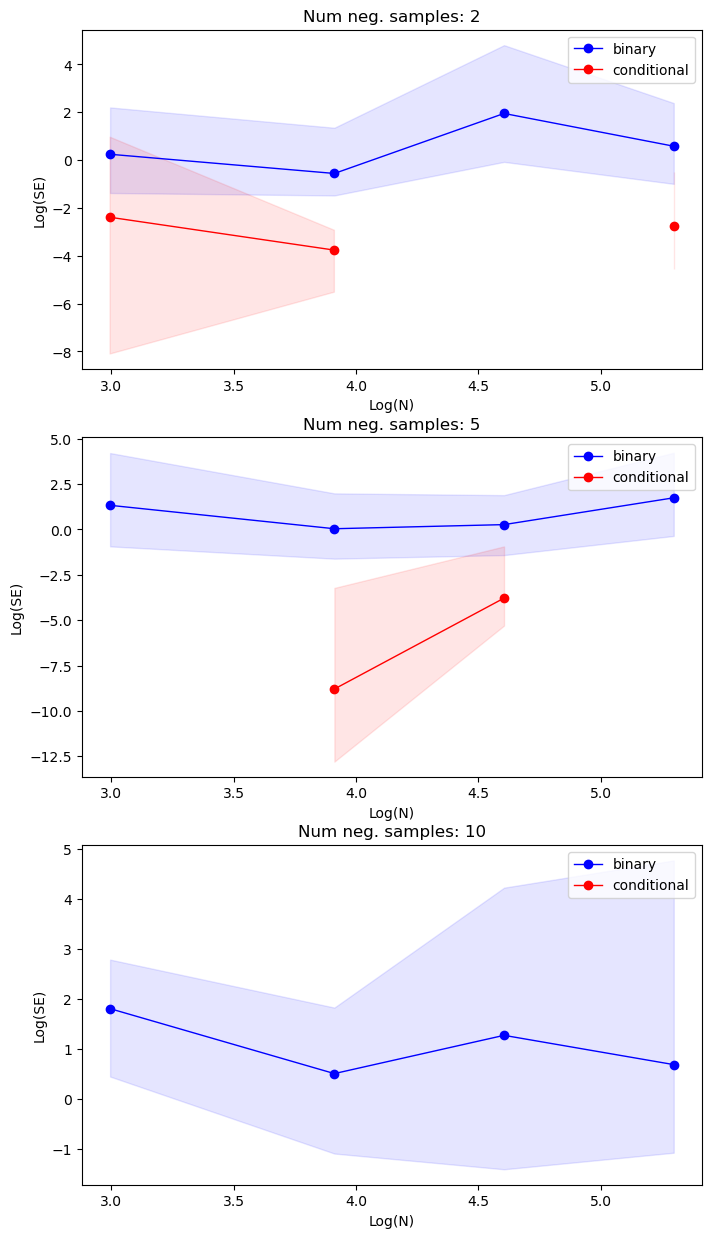

In [20]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()